# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from scipy.signal import firwin, lfilter, butter, filtfilt, spectrogram
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import convolve
from scipy.io.wavfile import write

## Reading Audio File

In [2]:
fs, y = wavfile.read('spoon_clap_clean.wav')  # Replace with your file path
y = y.astype(np.float32)

if y.ndim > 1:
    y = y.mean(axis=1)  # Convert stereo to mono

y = y / np.max(np.abs(y))  # Normalize
y = y[:(int)(len(y)/2)]
duration = len(y) / fs
print(f"Audio: {duration:.2f}s, Sample Rate: {fs} Hz")
Audio(y, rate=fs)

Audio: 12.97s, Sample Rate: 48000 Hz


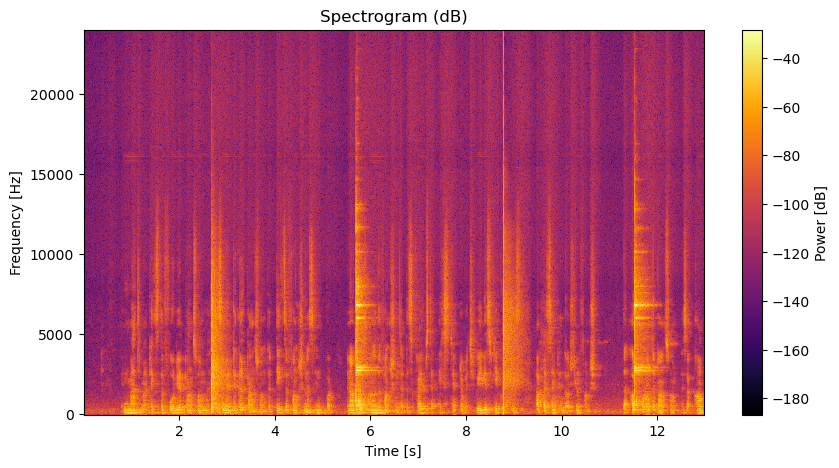

In [3]:

f, t, Sxx = spectrogram(y, fs=fs, nperseg = 1024, noverlap = 512, nfft= 1024)
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='auto', cmap="inferno")
plt.title('Spectrogram (dB)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')
plt.show()


In [4]:
def frame_signal(y, frame_length, hop_length):
    num_frames = 1 + (len(y) - frame_length) // hop_length
    frames = np.zeros((num_frames, frame_length))

    for i in range(num_frames):
        start = i * hop_length
        end = start + frame_length
        frames[i, :] = y[start:end]

    return frames

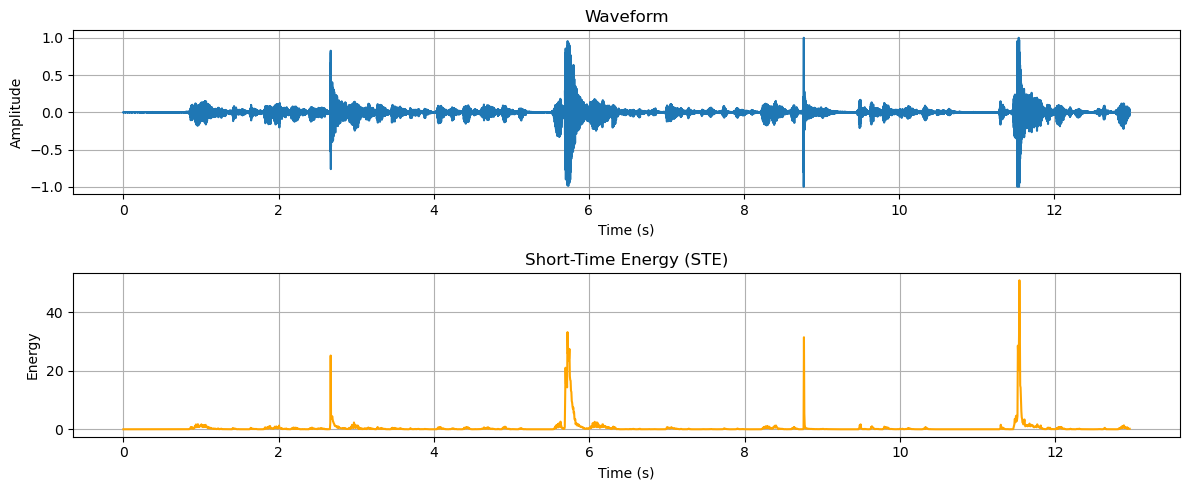

In [5]:
# Framing
frame_duration = 0.010  
hop_duration = 0.005    

frame_length = int(frame_duration * fs)
hop_length = int(hop_duration * fs)

frames = frame_signal(y, frame_length, hop_length)  # 

# Windowing
window = np.hamming(frame_length)
windowed_frames = frames * window

# STE
energy = np.sum(windowed_frames**2, axis=1)
frame_times = np.arange(len(energy)) * hop_length / fs

plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
time = np.arange(len(y)) / fs
plt.plot(time, y, label='Waveform')
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(frame_times, energy, color='orange', label='Short-Time Energy')
plt.title("Short-Time Energy (STE)")
plt.xlabel("Time (s)")
plt.ylabel("Energy")
plt.grid(True)
plt.tight_layout()
plt.show()

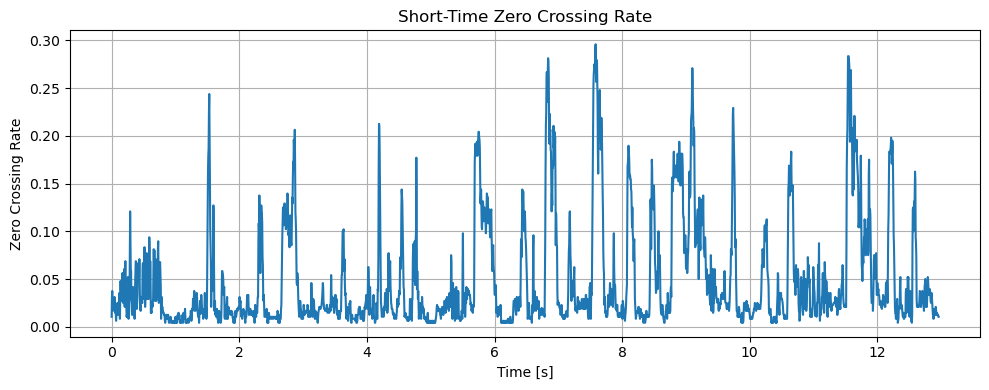

In [6]:
def zero_crossing_rate(signal, frame_size, hop_size):
    zcr = []
    for i in range(0, len(signal) - frame_size, hop_size):
        frame = signal[i:i+frame_size]
        # Count zero crossings in the frame
        zero_crossings = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
        zcr.append(zero_crossings / frame_size)  # Normalize by frame length
    return np.array(zcr)


zcr = zero_crossing_rate(y, frame_length, hop_length)

# Time axis for plotting
times = np.arange(len(zcr)) * hop_duration

# Plot ZCR
plt.figure(figsize=(10, 4))
plt.plot(times, zcr)
plt.xlabel("Time [s]")
plt.ylabel("Zero Crossing Rate")
plt.title("Short-Time Zero Crossing Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
ste_threshold = 0.4 * np.max(energy)  
# zcr_threshold = 0.9 * np.max(zcr)   


event_indices = np.where((energy > ste_threshold))[0]
event_times = frame_times[event_indices]

min_event_spacing = 0.2
filtered_event_times = []
last_time = -min_event_spacing

for t in event_times:
    if t - last_time >= min_event_spacing:
        filtered_event_times.append(t)
        last_time = t

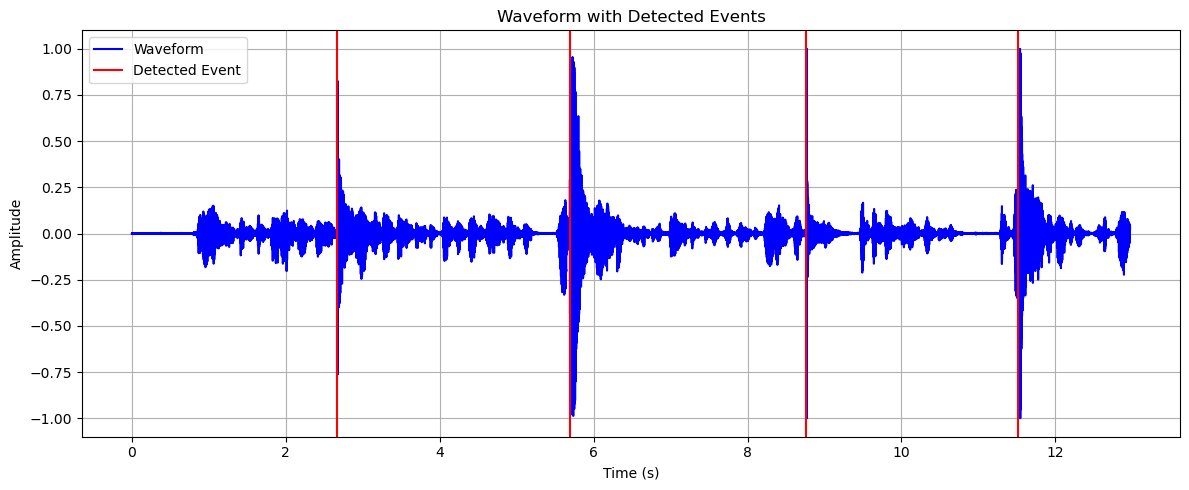

In [8]:
plt.figure(figsize=(12, 5))

# Plot original waveform
time = np.arange(len(y)) / fs
plt.plot(time, y, label='Waveform', color='blue')

# Overlay detected events
for t in filtered_event_times:
    plt.axvline(x=t, color='red', alpha=1, label='Detected Event')

# Prevent duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Waveform with Detected Events")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

## Band energy Ratios

In [9]:
from scipy.signal import spectrogram

f, t_spec, Sxx = spectrogram(y, fs, nperseg=1024, noverlap=512)
Sxx_db = 10 * np.log10(Sxx + 1e-10)

high_band = (f > 15000) & (f < 20000)
low_band = (f > 500) & (f < 4000)

high_energy = np.mean(Sxx_db[high_band, :], axis=0)
low_energy = np.mean(Sxx_db[low_band, :], axis=0)

energy_ratio = high_energy / (low_energy + 1e-10) 

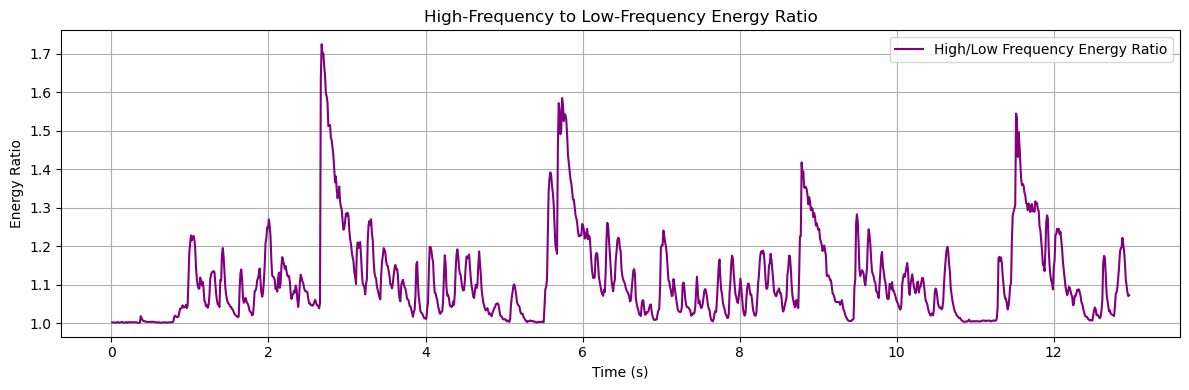

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(t_spec, energy_ratio, label='High/Low Frequency Energy Ratio', color='purple')
plt.xlabel("Time (s)")
plt.ylabel("Energy Ratio")
plt.title("High-Frequency to Low-Frequency Energy Ratio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

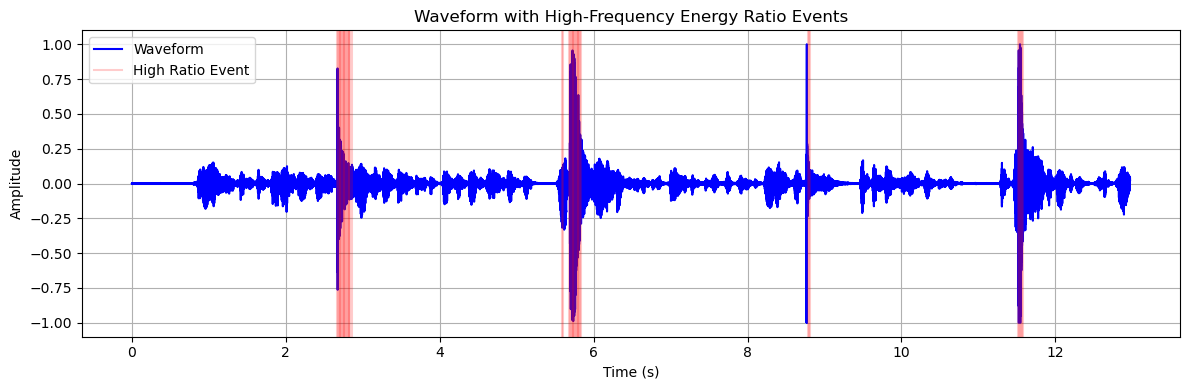

In [11]:
ratio_thresh = 1.38 
event_times = t_spec[energy_ratio > ratio_thresh]

plt.figure(figsize=(12, 4))
time = np.arange(len(y)) / fs
plt.plot(time, y, label="Waveform", color='blue')

for t in event_times:
    plt.axvline(x=t, color='red', alpha=0.2, label='High Ratio Event')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Waveform with High-Frequency Energy Ratio Events")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

### Windowing Effect

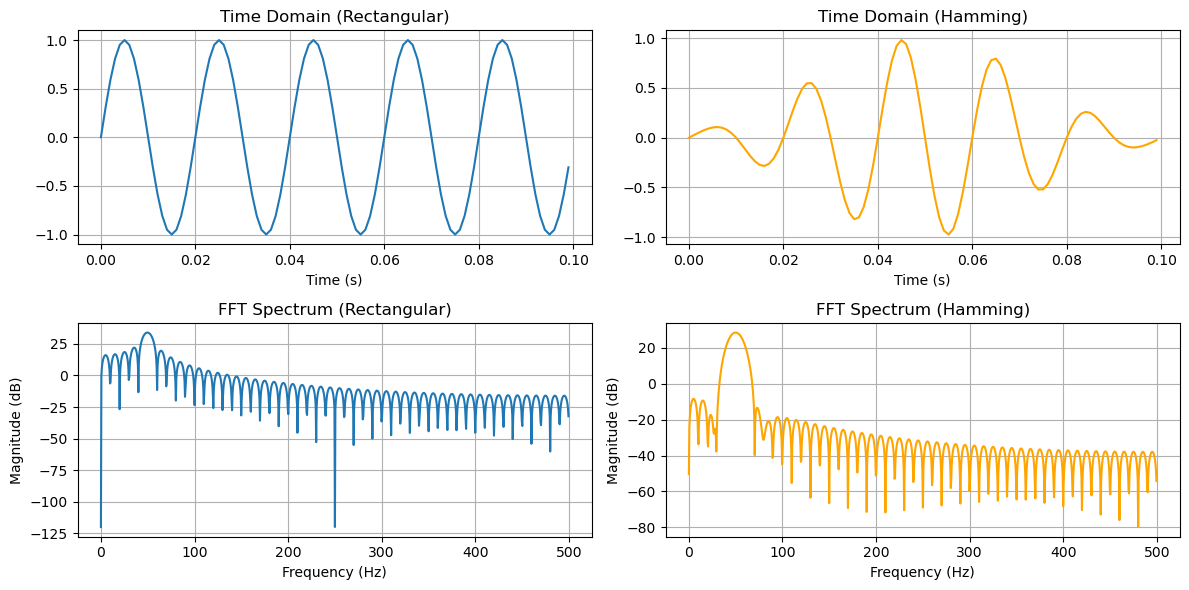

In [12]:
from scipy.signal import get_window

fs = 1000       
f = 50          
duration = 0.1  
t = np.linspace(0, duration, int(fs*duration), endpoint=False)
x = np.sin(2 * np.pi * f * t)

N = len(x)
rect_window = np.ones(N)
hamming_window = np.hamming(N)

x_rect = x * rect_window
x_hamming = x * hamming_window

def compute_fft(signal, fs):
    fft = np.fft.fft(signal, n=2048)
    freqs = np.fft.fftfreq(len(fft), 1/fs)
    return freqs[:len(freqs)//2], 20*np.log10(np.abs(fft[:len(fft)//2]) + 1e-6)

freqs, mag_rect = compute_fft(x_rect, fs)
_, mag_hamming = compute_fft(x_hamming, fs)

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(t, x_rect, label='Rectangular Window')
plt.title('Time Domain (Rectangular)')
plt.xlabel('Time (s)')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(t, x_hamming, label='Hamming Window', color='orange')
plt.title('Time Domain (Hamming)')
plt.xlabel('Time (s)')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(freqs, mag_rect, label='Rectangular Spectrum')
plt.title('FFT Spectrum (Rectangular)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(freqs, mag_hamming, label='Hamming Spectrum', color='orange')
plt.title('FFT Spectrum (Hamming)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)

plt.tight_layout()
plt.show()